# creating MNE-Python data structures

numpy array --> mne-python core data

In [1]:
import numpy as np

import mne

In [2]:
# Create some dummy metadata
n_channels = 32
sampling_freq = 200  # in Hertz
info = mne.create_info(n_channels, sfreq=sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 200.0 Hz
>


In [3]:
ch_names = [f'MEG{n:03}' for n in range(1, 10)] + ['EOG001']
ch_types = ['mag', 'grad', 'grad'] * 3 + ['eog']
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: MEG001, MEG002, MEG003, MEG004, MEG005, MEG006, MEG007, MEG008, ...
 chs: 3 Magnetometers, 6 Gradiometers, 1 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 10
 projs: []
 sfreq: 200.0 Hz
>


In [4]:
ch_names = ['Fp1', 'Fp2', 'Fz', 'Cz', 'Pz', 'O1', 'O2']
ch_types = ['eeg'] * 7
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fz, Cz, Pz, O1, O2
 chs: 7 EEG
 custom_ref_applied: False
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 200.0 Hz
>

In [5]:
info['description'] = 'My custom dataset'
info['bads'] = ['O1']  # Names of bad channels
print(info)

<Info | 10 non-empty values
 bads: 1 items (O1)
 ch_names: Fp1, Fp2, Fz, Cz, Pz, O1, O2
 chs: 7 EEG
 custom_ref_applied: False
 description: My custom dataset
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 200.0 Hz
>


In [6]:
# creating Raw objects

Creating RawArray with float64 data, n_channels=2, n_times=200
    Range : 0 ... 199 =      0.000 ...     0.995 secs
Ready.


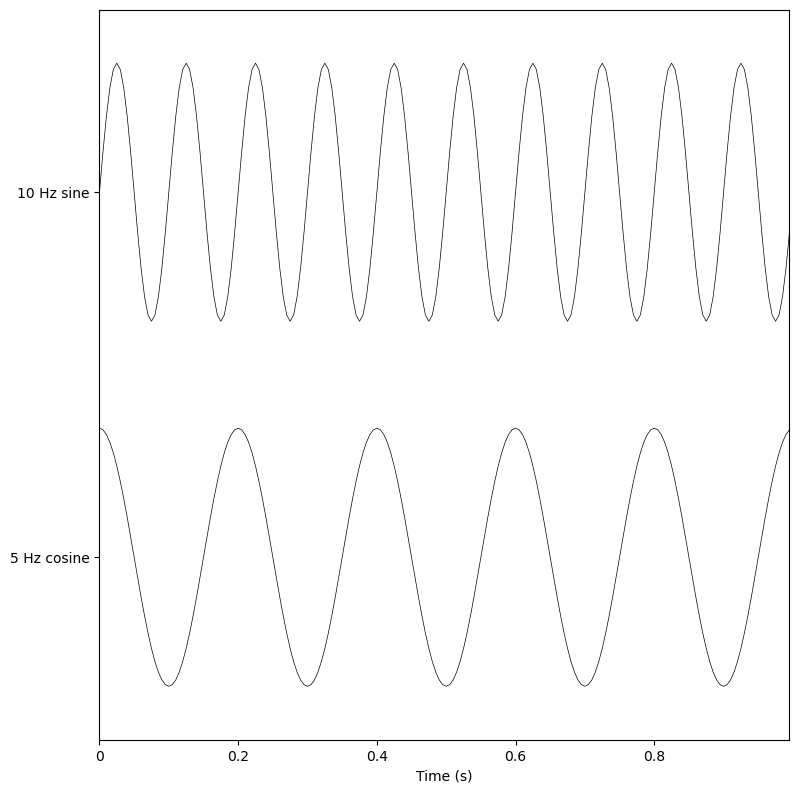

In [8]:
times = np.linspace(0, 1, sampling_freq, endpoint=False)
sine = np.sin(20 * np.pi * times)
cosine = np.cos(10 * np.pi * times)
data = np.array([sine, cosine])

info = mne.create_info(ch_names=['10 Hz sine', '5 Hz cosine'],
                       ch_types=['misc'] * 2,
                       sfreq=sampling_freq)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.plot(show_scrollbars=False, show_scalebars=False);

In [9]:
# creating Epochs objects

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


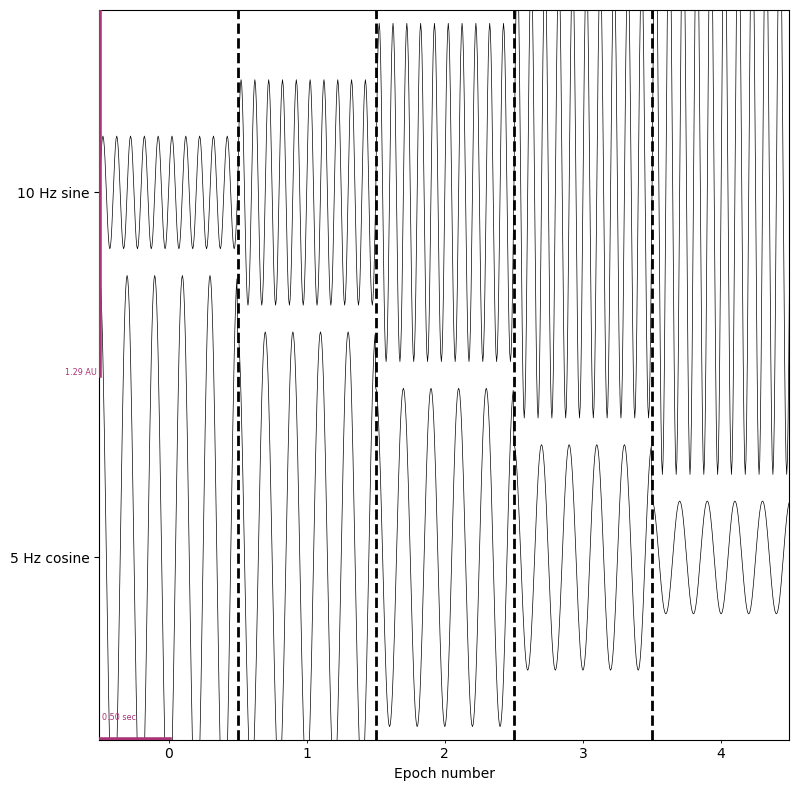

In [11]:
data = np.array([[0.2 * sine, 1.0 * cosine],
                 [0.4 * sine, 0.8 * cosine],
                 [0.6 * sine, 0.6 * cosine],
                 [0.8 * sine, 0.4 * cosine],
                 [1.0 * sine, 0.2 * cosine]])

simulated_epochs = mne.EpochsArray(data, info)
simulated_epochs.plot(picks='misc', show_scrollbars=False);

In [12]:
print(simulated_epochs.events[:, -1])

[1 1 1 1 1]


Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


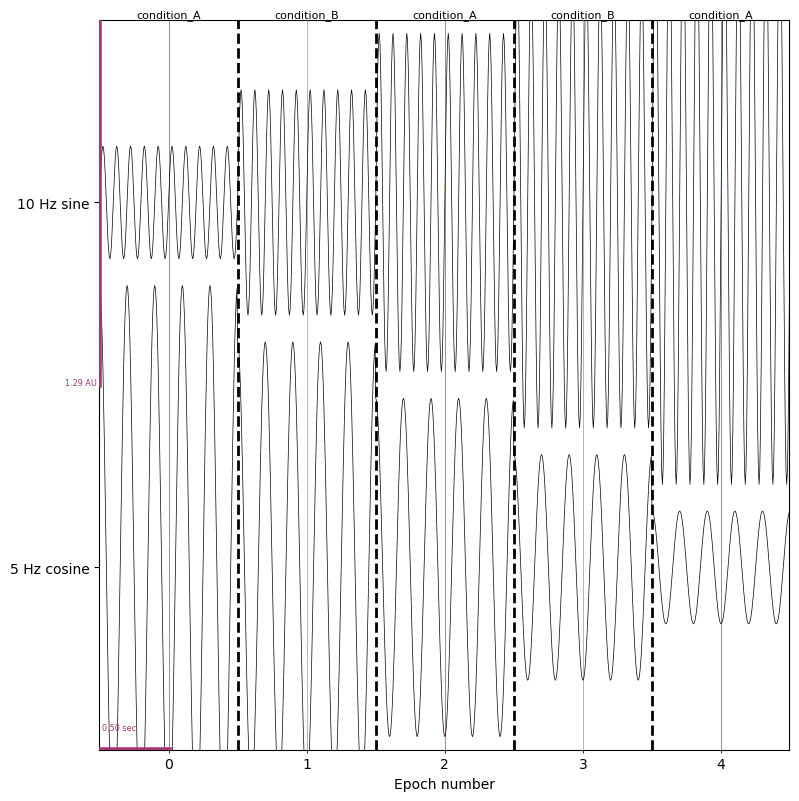

In [13]:
events = np.column_stack((np.arange(0, 1000, sampling_freq),
                          np.zeros(5, dtype=int),
                          np.array([1, 2, 1, 2, 1])))
event_dict = dict(condition_A=1, condition_B=2)
simulated_epochs = mne.EpochsArray(data, info, tmin=-0.5, events=events,
                                   event_id=event_dict)
simulated_epochs.plot(picks='misc', show_scrollbars=False, events=events,
                      event_id=event_dict);

In [ ]:
# creating Evoked objects

<Evoked | 'simulated' (average, N=5), -0.5 – 0.495 sec, baseline off, 2 ch, ~10 kB>


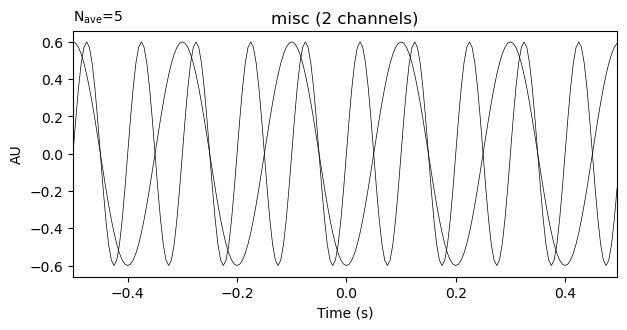

In [15]:
# Create the Evoked object
evoked_array = mne.EvokedArray(data.mean(axis=0), info, tmin=-0.5,
                               nave=data.shape[0], comment='simulated')
print(evoked_array)
evoked_array.plot();

### corrupt known signal with point spread

In [16]:
import os.path as op

import numpy as np

import mne
from mne.datasets import sample

from mne.minimum_norm import read_inverse_operator, apply_inverse
from mne.simulation import simulate_stc, simulate_evoked

In [17]:
seed = 42

# parameters for inverse method
method = 'sLORETA'
snr = 3.
lambda2 = 1.0 / snr ** 2

# signal simulation parameters
# do not add extra noise to the known signals
nave = np.inf
T = 100
times = np.linspace(0, 1, T)
dt = times[1] - times[0]

# Paths to MEG data
data_path = sample.data_path()
subjects_dir = op.join(data_path, 'subjects')
fname_fwd = op.join(data_path, 'MEG', 'sample',
                    'sample_audvis-meg-oct-6-fwd.fif')
fname_inv = op.join(data_path, 'MEG', 'sample',
                    'sample_audvis-meg-oct-6-meg-fixed-inv.fif')

fname_evoked = op.join(data_path, 'MEG', 'sample',
                       'sample_audvis-ave.fif')

# load the MEG data

In [18]:
fwd = mne.read_forward_solution(fname_fwd)
fwd = mne.convert_forward_solution(fwd, force_fixed=True, surf_ori=True,
                                   use_cps=False)
fwd['info']['bads'] = []
inv_op = read_inverse_operator(fname_inv)

raw = mne.io.read_raw_fif(op.join(data_path, 'MEG', 'sample',
                                  'sample_audvis_raw.fif'))
raw.info['bads'] = []
raw.set_eeg_reference(projection=True)
events = mne.find_events(raw)
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2}
epochs = mne.Epochs(raw, events, event_id, baseline=(None, 0), preload=True)
evoked = epochs.average()

labels = mne.read_labels_from_annot('sample', subjects_dir=subjects_dir)
label_names = [label.name for label in labels]
n_labels = len(labels)

Reading forward solution from /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
Reading inverse operator decomposition from /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-fixed-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance 

# noise covariance

In [19]:
cov = mne.compute_covariance(epochs, tmin=None, tmax=0.)

Computing rank from data with rank=None
    Using tolerance 1.4e-08 (2.2e-16 eps * 306 dim * 2.1e+05  max singular value)
    Estimated rank (mag + grad): 303
    MEG: rank 303 computed from 306 data channels with 3 projectors
    Using tolerance 4.9e-11 (2.2e-16 eps * 60 dim * 3.7e+03  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 60 data channels with 1 projector
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 366 -> 362
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 17545
[done]


## generate sinusoids in 2 spatially distant labels

In [20]:
# The known signal is all zero-s off of the two labels of interest
signal = np.zeros((n_labels, T))
idx = label_names.index('inferiorparietal-lh')
signal[idx, :] = 1e-7 * np.sin(5 * 2 * np.pi * times)
idx = label_names.index('rostralmiddlefrontal-rh')
signal[idx, :] = 1e-7 * np.sin(7 * 2 * np.pi * times)

#### find the center vertices in source space of each label

In [21]:
hemi_to_ind = {'lh': 0, 'rh': 1}
for i, label in enumerate(labels):
    # The `center_of_mass` function needs labels to have values.
    labels[i].values.fill(1.)

    # Restrict the eligible vertices to be those on the surface under
    # consideration and within the label.
    surf_vertices = fwd['src'][hemi_to_ind[label.hemi]]['vertno']
    restrict_verts = np.intersect1d(surf_vertices, label.vertices)
    com = labels[i].center_of_mass(subjects_dir=subjects_dir,
                                   restrict_vertices=restrict_verts,
                                   surf='white')

    # Convert the center of vertex index from surface vertex list to Label's
    # vertex list.
    cent_idx = np.where(label.vertices == com)[0][0]

    # Create a mask with 1 at center vertex and zeros elsewhere.
    labels[i].values.fill(0.)
    labels[i].values[cent_idx] = 1.

    # Print some useful information about this vertex and label
    if 'transversetemporal' in label.name:
        dist, _ = label.distances_to_outside(
            subjects_dir=subjects_dir)
        dist = dist[cent_idx]
        area = label.compute_area(subjects_dir=subjects_dir)
        # convert to equivalent circular radius
        r = np.sqrt(area / np.pi)
        print(f'{label.name} COM vertex is {dist * 1e3:0.1f} mm from edge '
              f'(label area equivalent to a circle with r={r * 1e3:0.1f} mm)')

    Triangle neighbors and vertex normals...
transversetemporal-lh COM vertex is 7.5 mm from edge (label area equivalent to a circle with r=11.5 mm)
    Triangle neighbors and vertex normals...
transversetemporal-rh COM vertex is 6.8 mm from edge (label area equivalent to a circle with r=10.8 mm)


#### create source-space data with known signals

In [22]:
stc_gen = simulate_stc(fwd['src'], labels, signal, times[0], dt,
                       value_fun=lambda x: x)

In [23]:
kwargs = dict(subjects_dir=subjects_dir, hemi='split', smoothing_steps=4,
              time_unit='s', initial_time=0.05, size=1200,
              views=['lat', 'med'])
clim = dict(kind='value', pos_lims=[1e-9, 1e-8, 1e-7])
brain_gen = stc_gen.plot(clim=clim, **kwargs)

Using pyvistaqt 3d backend.

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/pyvistaqt/plotting.py:733: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.app_window.setBaseSize(*window_size)
/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/pyvistaqt/dialog.py:74: RuntimeWarning: Movie saving aborted:
Traceback (most recent call last):
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 3566, in _make_movie_frames
    images = [
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 3567, in <listcomp>
    self.screenshot(time_viewer=time_viewer)
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 3035, in screenshot
    img = self._renderer.screenshot(mode)
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/backends/_pyvista.py", line 692, in screenshot
    re

### simulate sensor-space signals

In [24]:
evoked_gen = simulate_evoked(fwd, stc_gen, evoked.info, cov, nave,
                             random_state=seed)

# Map the simulated sensor-space data to source-space using the inverse
# operator.
stc_inv = apply_inverse(evoked_gen, inv_op, lambda2, method=method)

Projecting source estimate to sensor space...
[done]
4 projection items deactivated
Created an SSP operator (subspace dimension = 3)
4 projection items activated
SSP projectors applied...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Applying inverse operator to ""...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  99.7% variance
    sLORETA...
[done]


In [25]:
brain_inv = stc_inv.plot(**kwargs);

Using control points [0.45968308 0.57021267 1.69354621]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/pyvistaqt/dialog.py:74: RuntimeWarning: Movie saving aborted:
Traceback (most recent call last):
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 3566, in _make_movie_frames
    images = [
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 3567, in <listcomp>
    self.screenshot(time_viewer=time_viewer)
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 3035, in screenshot
    img = self._renderer.screenshot(mode)
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/backends/_pyvista.py", line 692, in screenshot
    return _take_3d_screenshot(figure=self.figure, mode=mode,
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/backends/_pyvista.py", line 1114, in _take_3d_screenshot
    return figure.plotter.screenshot(
AttributeError: 'NoneType' object has no 

# DICS for power mapping

In [26]:
import os.path as op
import numpy as np
from scipy.signal import welch, coherence, unit_impulse
from matplotlib import pyplot as plt

import mne
from mne.simulation import simulate_raw, add_noise
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.time_frequency import csd_morlet
from mne.beamformer import make_dics, apply_dics_csd

# We use the MEG and MRI setup from the MNE-sample dataset
data_path = sample.data_path(download=False)
subjects_dir = op.join(data_path, 'subjects')

# Filenames for various files we'll be using
meg_path = op.join(data_path, 'MEG', 'sample')
raw_fname = op.join(meg_path, 'sample_audvis_raw.fif')
fwd_fname = op.join(meg_path, 'sample_audvis-meg-eeg-oct-6-fwd.fif')
cov_fname = op.join(meg_path, 'sample_audvis-cov.fif')
fwd = mne.read_forward_solution(fwd_fname)

# Seed for the random number generator
rand = np.random.RandomState(42)

Reading forward solution from /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


In [ ]:
# data simulation

In [27]:
sfreq = 50.  # Sampling frequency of the generated signal
n_samp = int(round(10. * sfreq))
times = np.arange(n_samp) / sfreq  # 10 seconds of signal
n_times = len(times)


def coh_signal_gen():
    """Generate an oscillating signal.

    Returns
    -------
    signal : ndarray
        The generated signal.
    """
    t_rand = 0.001  # Variation in the instantaneous frequency of the signal
    std = 0.1  # Std-dev of the random fluctuations added to the signal
    base_freq = 10.  # Base frequency of the oscillators in Hertz
    n_times = len(times)

    # Generate an oscillator with varying frequency and phase lag.
    signal = np.sin(2.0 * np.pi *
                    (base_freq * np.arange(n_times) / sfreq +
                     np.cumsum(t_rand * rand.randn(n_times))))

    # Add some random fluctuations to the signal.
    signal += std * rand.randn(n_times)

    # Scale the signal to be in the right order of magnitude (~100 nAm)
    # for MEG data.
    signal *= 100e-9

    return signal

In [28]:
signal1 = coh_signal_gen()
signal2 = coh_signal_gen()

fig, axes = plt.subplots(2, 2, figsize=(8, 4))

# Plot the timeseries
ax = axes[0][0]
ax.plot(times, 1e9 * signal1, lw=0.5)
ax.set(xlabel='Time (s)', xlim=times[[0, -1]], ylabel='Amplitude (Am)',
       title='Signal 1')
ax = axes[0][1]
ax.plot(times, 1e9 * signal2, lw=0.5)
ax.set(xlabel='Time (s)', xlim=times[[0, -1]], title='Signal 2')

# Power spectrum of the first timeseries
f, p = welch(signal1, fs=sfreq, nperseg=128, nfft=256)
ax = axes[1][0]
# Only plot the first 100 frequencies
ax.plot(f[:100], 20 * np.log10(p[:100]), lw=1.)
ax.set(xlabel='Frequency (Hz)', xlim=f[[0, 99]],
       ylabel='Power (dB)', title='Power spectrum of signal 1')

# Compute the coherence between the two timeseries
f, coh = coherence(signal1, signal2, fs=sfreq, nperseg=100, noverlap=64)
ax = axes[1][1]
ax.plot(f[:50], coh[:50], lw=1.)
ax.set(xlabel='Frequency (Hz)', xlim=f[[0, 49]], ylabel='Coherence',
       title='Coherence between the timeseries')
fig.tight_layout()

In [29]:
# The locations on the cortex where the signal will originate from. These
# locations are indicated as vertex numbers.
vertices = [[146374], [33830]]

# Construct SourceEstimates that describe the signals at the cortical level.
data = np.vstack((signal1, signal2))
stc_signal = mne.SourceEstimate(
    data, vertices, tmin=0, tstep=1. / sfreq, subject='sample')
stc_noise = stc_signal * 0.

In [30]:
snr = 1.  # Signal-to-noise ratio. Decrease to add more noise.

In [31]:
# Read the info from the sample dataset. This defines the location of the
# sensors and such.
info = mne.io.read_raw(raw_fname).crop(0, 1).resample(50).info

# Only use gradiometers
picks = mne.pick_types(info, meg='grad', stim=True, exclude=())
mne.pick_info(info, picks, copy=False)

# Define a covariance matrix for the simulated noise. In this tutorial, we use
# a simple diagonal matrix.
cov = mne.cov.make_ad_hoc_cov(info)
cov['data'] *= (20. / snr) ** 2  # Scale the noise to achieve the desired SNR

# Simulate the raw data, with a lowpass filter on the noise
stcs = [(stc_signal, unit_impulse(n_samp, dtype=int) * 1),
        (stc_noise, unit_impulse(n_samp, dtype=int) * 2)]  # stacked in time
duration = (len(stc_signal.times) * 2) / sfreq
raw = simulate_raw(info, stcs, forward=fwd)
add_noise(raw, cov, iir_filter=[4, -4, 0.8], random_state=rand)

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000-10.000 sec
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000-10.000 sec
    2 STC iterations provided
[done]
Adding noise to 204/213 channels (204 channels in cov)


<RawArray | 213 x 1000 (20.0 s), ~4.8 MB, data loaded>

2 events found
Event IDs: [1 2]
Not setting metadata
2 matching events found
No baseline correction applied
3 projection items activated
Using data from preloaded Raw for 2 events and 500 original time points ...
0 bad epochs dropped


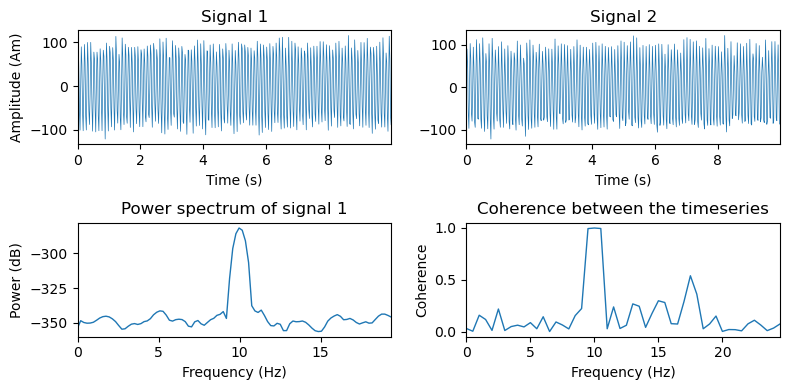

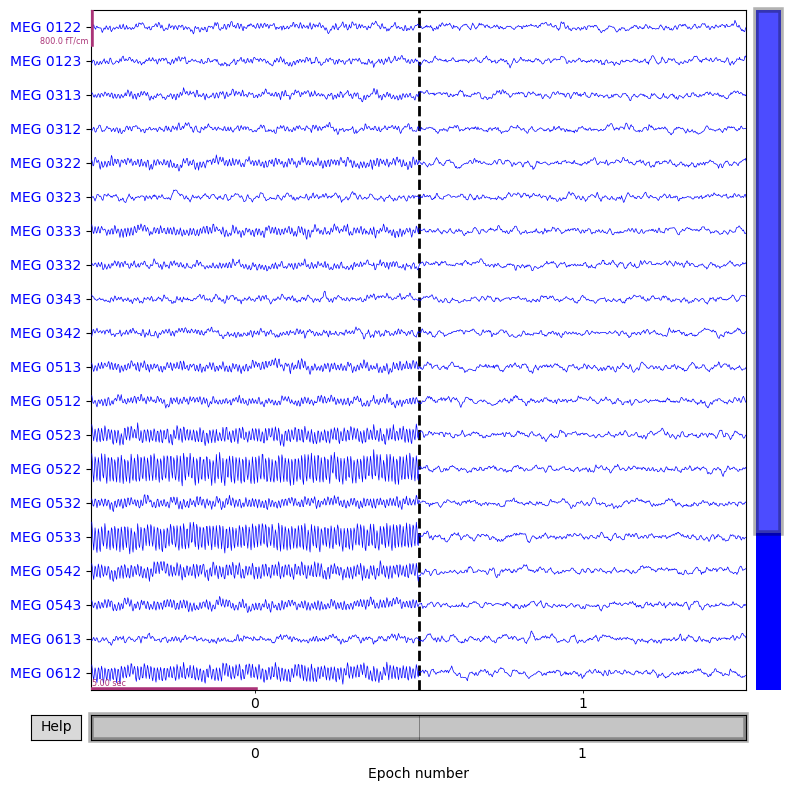

In [32]:
events = mne.find_events(raw, initial_event=True)
tmax = (len(stc_signal.times) - 1) / sfreq
epochs = mne.Epochs(raw, events, event_id=dict(signal=1, noise=2),
                    tmin=0, tmax=tmax, baseline=None, preload=True)
assert len(epochs) == 2  # ensure that we got the two expected events

# Plot some of the channels of the simulated data that are situated above one
# of our simulated sources.
picks = mne.pick_channels(epochs.ch_names,
                          mne.read_vectorview_selection('Left-frontal'))
epochs.plot(picks=picks);

In [ ]:
# power mapping

In [33]:
# Compute the inverse operator
fwd = mne.read_forward_solution(fwd_fname)
inv = make_inverse_operator(epochs.info, fwd, cov)

# Apply the inverse model to the trial that also contains the signal.
s = apply_inverse(epochs['signal'].average(), inv)

# Take the root-mean square along the time dimension and plot the result.
s_rms = np.sqrt((s ** 2).mean())
title = 'MNE-dSPM inverse (RMS)'
brain = s_rms.plot('sample', subjects_dir=subjects_dir, hemi='both', figure=1,
                   size=600, time_label=title, title=title)

# Indicate the true locations of the source activity on the plot.
brain.add_foci(vertices[0][0], coords_as_verts=True, hemi='lh')
brain.add_foci(vertices[1][0], coords_as_verts=True, hemi='rh')

# Rotate the view and add a title.
brain.show_view(azimuth=0, elevation=0, distance=550, focalpoint=(0, 0, 0))

Reading forward solution from /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
 

In [34]:
# Estimate the cross-spectral density (CSD) matrix on the trial containing the
# signal.
csd_signal = csd_morlet(epochs['signal'], frequencies=[10])

# Compute the spatial filters for each vertex, using two approaches.
filters_approach1 = make_dics(
    info, fwd, csd_signal, reg=0.05, pick_ori='max-power', depth=1.,
    inversion='single', weight_norm=None, real_filter=True)
print(filters_approach1)

filters_approach2 = make_dics(
    info, fwd, csd_signal, reg=0.05, pick_ori='max-power', depth=None,
    inversion='matrix', weight_norm='unit-noise-gain', real_filter=True)
print(filters_approach2)

# You can save these to disk with:
# filters_approach1.save('filters_1-dics.h5')

# Compute the DICS power map by applying the spatial filters to the CSD matrix.
power_approach1, f = apply_dics_csd(csd_signal, filters_approach1)
power_approach2, f = apply_dics_csd(csd_signal, filters_approach2)

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Identifying common channels ...
Dropped the following channels:
['MEG 0511', 'EEG 036', 'EEG 007', 'MEG 0421', 'MEG 0721', 'MEG 0341', 'STI 006', 'EEG 018', 'MEG 2121', 'EEG 037', 'MEG 2011', 'EEG 013', 'MEG 1611', 'MEG 2411', 'MEG 0121', 'EEG 001', 'MEG 2041', 'MEG 1111', 'MEG 1231', 'MEG 1331', 'EEG 056', 'EEG 039', 'MEG 2311', 'MEG 1831', 'EEG 046', 'EEG 026', 'STI 014', 'EEG 004', 'EEG 058', 'MEG 1841', 'MEG 1441', 'MEG 2141', 'MEG 1221', 'EEG 034', 'MEG 1211', 'EEG 017', 'EEG 003', 'MEG 2521', 'EEG 038', 'MEG 0811', 'EEG 027', 'EEG 057', 'MEG 2331', 'MEG 2221', 'EEG 011', 'MEG 1421', 'MEG 2641', 'MEG 2511', 'EEG 045', 'MEG 2211', 'EEG 032', 'MEG 1511', 'MEG 1911', 'MEG 0731', 'MEG 1411', 'EEG 033', 'MEG 1541', 'EEG 055', 'STI 003', 'MEG 1941', 'EEG 020', 'MEG 0431', 'MEG 1621', 'MEG 0641', 'MEG 1731', 'MEG 1311', 'EEG 024', 'MEG 0411', 'EEG 016', 'MEG 2541', 'EEG 006', 'EEG 022', 'MEG 2611', 'MEG 1721', 'STI 002', 'EEG 030', 'MEG 0141', 'EEG 009', 'MEG 2021', 'EEG 008', 'MEG 1741'

In [35]:
def plot_approach(power, n):
    """Plot the results on a brain."""
    title = 'DICS power map, approach %d' % n
    brain = power_approach1.plot(
        'sample', subjects_dir=subjects_dir, hemi='both',
        size=600, time_label=title, title=title)
    # Indicate the true locations of the source activity on the plot.
    brain.add_foci(vertices[0][0], coords_as_verts=True, hemi='lh', color='b')
    brain.add_foci(vertices[1][0], coords_as_verts=True, hemi='rh', color='b')
    # Rotate the view and add a title.
    brain.show_view(azimuth=0, elevation=0, distance=550, focalpoint=(0, 0, 0))
    return brain


brain1 = plot_approach(power_approach1, 1)

Using control points [5.42918831e-25 6.04345299e-25 1.40589757e-24]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


In [36]:
brain2 = plot_approach(power_approach2, 2)

Using control points [5.42918831e-25 6.04345299e-25 1.40589757e-24]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
